# 🐷📊 BACON Window stats

[BAckport and CONfig](https://wikitech.wikimedia.org/wiki/Backport_windows) (BACON) windows have happened for a long time.

This repo gathers data about the windows going back for the past 5 years.

In [58]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
    
engine = create_engine('sqlite:///data/bacon.db')
df = pd.read_sql('''
SELECT
    strftime('%H', datetime, 'unixepoch') as hour,
    count(url) as patches
FROM window w
join patch_window pw on w.id = pw.window_id
join patch p on p.id = pw.window_id
group by hour
''', engine)

# Makes your data 538% better...I think
plt.style.use('fivethirtyeight')
df

hour  patches
0    00      548
1    11      738
2    12      379
3    13      551
4    14      321
5    15      284
6    16      165
7    17       79
8    18      766
9    19      464
10   23     1271

Text(0.5, 1.0, 'Patches deploy in backports (2016–2021)')

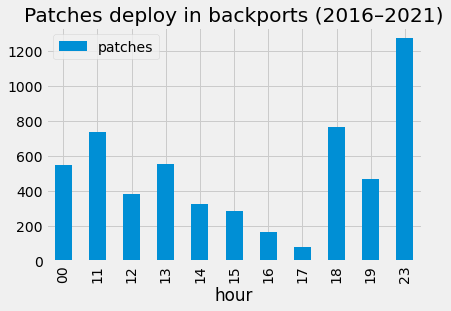

In [59]:
df.set_index('hour').plot(kind='bar')
plt.title('Patches deploy in backports (2016–2021)')

# What are these outliers?

In [60]:
df = pd.read_sql('''
SELECT
    distinct strftime('https://wikitech.wikimedia.org/wiki/Deployments/Archive/%Y/%m', datetime, 'unixepoch') as link,
    strftime('%H', datetime, 'unixepoch') as hour
FROM window w
join patch_window pw on w.id = pw.window_id
join patch p on p.id = pw.patch_id
WHERE hour == '17'
''', engine)

from IPython.display import display, Markdown
for link in df['link']:
    print(link)

https://wikitech.wikimedia.org/wiki/Deployments/Archive/2018/03
https://wikitech.wikimedia.org/wiki/Deployments/Archive/2018/04
https://wikitech.wikimedia.org/wiki/Deployments/Archive/2018/05
https://wikitech.wikimedia.org/wiki/Deployments/Archive/2018/06
https://wikitech.wikimedia.org/wiki/Deployments/Archive/2018/11
https://wikitech.wikimedia.org/wiki/Deployments/Archive/2018/12
https://wikitech.wikimedia.org/wiki/Deployments/Archive/2019/01
https://wikitech.wikimedia.org/wiki/Deployments/Archive/2019/02
https://wikitech.wikimedia.org/wiki/Deployments/Archive/2019/03


I guess ^ all look legit...

## What about names...

In [90]:
def remap_name(name):
    name = name.lower()
    if 'mid-day' in name:
        return 'utc-morning (11:00)'
    if 'morning' in name:
        return 'utc-evening (16:00)'
    if 'evening' in name:
        return 'utc-late (23:00)'

df = pd.read_sql('''
SELECT
    name,
    count(url) as patches
FROM window w
join patch_window pw on w.id = pw.window_id
join patch p on p.id = pw.patch_id
group by name
''', engine)

df['name']=df['name'].map(remap_name)
df.groupby('name').sum()

patches
name                        
utc-evening (16:00)     1758
utc-late (23:00)        1819
utc-morning (11:00)     1989

Text(0.5, 1.0, 'Patches per BACON Window')

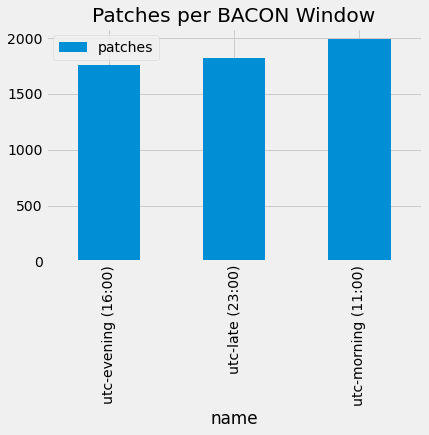

In [91]:
df = df.groupby('name').sum().plot(kind='bar')
plt.title('Patches per BACON Window')

How is it possible that we deploy the most patches at 23:00 hours, but utc-late is the least popular...?

In [83]:
df = pd.read_sql('''
SELECT
    name,
    strftime('%H', datetime, 'unixepoch') as hour,
    count(url) as patches
FROM window w
JOIN patch_window pw on w.id = pw.window_id
JOIN patch p on p.id = pw.patch_id
GROUP BY hour
ORDER BY name, patches
''', engine)
df

name hour  patches
0   European Mid-day SWAT(Max 6 patches)   12      379
1   European Mid-day SWAT(Max 6 patches)   11      738
2   European Mid-day SWAT(Max 8 patches)   14      321
3   European Mid-day SWAT(Max 8 patches)   13      551
4           Evening SWAT (Max 8 patches)   00      548
5           Evening SWAT (Max 8 patches)   23     1271
6           Morning SWAT (Max 8 patches)   17       79
7           Morning SWAT (Max 8 patches)   16      165
8           Morning SWAT (Max 8 patches)   19      464
9            Morning SWAT(Max 8 patches)   15      284
10           Morning SWAT(Max 8 patches)   18      766

I guess ^ is why: we rarely moved `Evening SWAT` but everything else kinda moves around